In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob, os
import numpy as np
from comet_ml import Experiment, Optimizer
import pickle
import logging
import sys
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
os.environ['TF_KERAS'] = '1'
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Lambda, BatchNormalization, TimeDistributed, \
     Bidirectional, Input, concatenate, Flatten, RepeatVector, Activation, Multiply, Permute
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model, Sequence

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import tensorflow as tf

/home/anasab/tf2conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anasab/tf2conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anasab/tf2conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anasab/tf2conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# only reserve 1 GPU

In [4]:
# tf.enable_eager_execution()
# my_seed = 1234
# tf.set_random_seed(my_seed)

In [5]:
logger = logging.getLogger('training')
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.setLevel(logging.DEBUG)

In [6]:
tf.test.is_gpu_available()

True

# Read data

In [7]:
def read_subject_writings(subject_file):
    writings = []
    with open(subject_file) as sf:
        contents = sf.read()
        root = ET.fromstring(contents)
        try:
            subject = root.findall('ID')[0].text.strip()
        except Exception:
            print('Cannot extract ID', contents[:500], '\n-------\n')        
        for w in root.iter('WRITING'):
            subject_writings = {'subject': subject}
            for title in w.findall('TITLE'):
                subject_writings['title'] = title.text
            for text in w.findall('TEXT'):
                subject_writings['text'] = text.text
            for date in w.findall('DATE'):
                subject_writings['date'] = date.text
            writings.append(subject_writings)
    return writings

In [8]:
root_dir = '/home/anasab/' 
# root_dir = '/home/ana/'

### eRisk 2020 T1

In [9]:
datadir_T1 = root_dir + '/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/data/'
labels_file_T1 = root_dir + '/eRisk/data//eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/golden_truth.txt'

In [10]:
def read_texts_2020(datadir_T1, labels_file_T1):
    writings = []
    for subject_file in os.listdir(datadir_T1):
        print(subject_file)
        writings.extend(read_subject_writings(os.path.join(datadir_T1, subject_file)))
    writings_df = pd.DataFrame(writings)

    labels_T1 = pd.read_csv(labels_file_T1, delimiter=' ', names=['subject', 'label'])
    labels_T1 = labels_T1.set_index('subject')

    writings_df['label'] = writings_df['subject'].apply(
    lambda s: labels_T1.loc[s, 'label'])
    
    return writings_df



### eRisk 2019 T1 (Anorexia)

In [11]:
datadirs_T1_2019 = {
    'train': ['2018 test/', '2018 train/positive_examples/', '2018 train/negative_examples/'],
    'test': ['data/']
}
datadir_root_T1_2019 = {
    'train': root_dir + '/eRisk/data/past/eRisk2019_T1/training data - t1/',
    'test': root_dir + '/eRisk/data/past/eRisk2019_T1/test data - T1/'
}
    
labels_files_T1_2019 = {
    'train': ['2018 train/risk_golden_truth.txt', '2018 test/risk-golden-truth-test.txt'],
    'test': ['T1_erisk_golden_truth.txt']
}

In [12]:
def read_texts_2019(datadir_root_T1_2019,
                   datadirs_T1_2019,
                   labels_files_T1_2019,
                   test_suffix='0000'):
    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()

    for subset in ('train', 'test'):
        for subdir in [os.path.join(datadir_root_T1_2019[subset], subp) for subp in datadirs_T1_2019[subset]]:
            if subset=='train':
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir, chunkdir) 
                             for chunkdir in os.listdir(subdir)]
            else:
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir)]
                
            for chunkdir in chunkdirs:
                if not os.path.isdir(chunkdir):
                    continue
                for subject_file in os.listdir(chunkdir):
                    writings[subset].extend(read_subject_writings(os.path.join(chunkdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        # add a suffix for users in the test -- the numbers are duplicated with the ones in train
        if subset=='test':
            writings_df_part['subject'] = writings_df_part['subject'].apply(lambda s: s+test_suffix)
            print(subset, writings_df_part.subject)
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

        for label_file in labels_files_T1_2019[subset]:
            labels = pd.read_csv(os.path.join(datadir_root_T1_2019[subset], label_file), 
                                 delimiter='\s+', names=['subject', 'label'])
            # add a suffix for users in the test -- the numbers are duplicated with the ones in train
            if subset=='test':
                labels['subject'] = labels['subject'].apply(lambda s: s+test_suffix)
            labels_df = pd.concat([labels_df, labels])
    labels_df = labels_df.drop_duplicates()
    labels_df = labels_df.set_index('subject')

    writings_df = writings_df.drop_duplicates()
    
    writings_df = writings_df.join(labels_df, on='subject')
    
    return writings_df

## Preprocess text

In [13]:
# writings_df = read_texts_2020(datadir_T1, labels_file_T1)
# writings_df = read_texts_2019(datadir_root_T1_2019,
#                    datadirs_T1_2019,
#                    labels_files_T1_2019)
writings_df = pickle.load(open('data/writings_df_anorexia_liwc', 'rb'))

# CLPsych
import json
# writings_df = pd.DataFrame.from_dict(json.load(open('data/writings_df_clpsych_liwc_affect.json')))#read_texts_clpsych(datadir_root_clpsych, datadirs_clpsych, labels_files_clpsych)
#     writings_df_test = pd.DataFrame.from_dict(json.load(open('writings_df_%s_test.json' % dataset_type)))#read_texts_clpsych(datadir_root_clpsych, datadirs_clpsych, labels_files_clpsych)
#     writings_df_test = read_texts_clpsych(datadir_root_clpsych, datadirs_clpsych, labels_files_clpsych)
# label_by = ['depression', 'ptsd']
# writings_df = writings_df.drop(writings_df[writings_df['condition']=='depression'].index)
# writings_df['label'] = writings_df['condition'].apply(lambda c: 1 if c in label_by else 0)

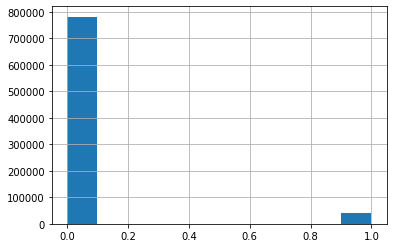

In [14]:
writings_df.label.hist()

In [15]:
writings_df.head()

,date,subject,text,title,subset,label,tokenized_title,title_len,tokenized_text,text_len,...,quant,sad,motion,verb,ingest,adverb,negemo,achieve,death,article
0,2016-12-01 07:47:48,subject5452,,mew_irl,train,0,[mew_irl],1.0,[],NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
1,2016-11-23 03:42:13,subject5452,,Trippy Kong.,train,0,"[trippy, kong]",2.0,[],NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,2016-11-22 22:12:02,subject5452,,Dk rap but the acid is slowly kicking in.,train,0,"[dk, rap, but, the, acid, is, slowly, kicking,...",9.0,[],NaN,...,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.111111
3,2016-11-09 21:35:42,subject5452,America just did a heel turn.,,train,0,[],NaN,"[america, just, did, a, heel, turn]",6.0,...,0.0,0.0,0.0,0.333333,0.0,0.166667,0.0,0.0,0.0,0.166667
4,2016-11-05 08:05:15,subject5452,,Pokemon theme but everytime they say Pokemon ...,train,0,"[pokemon, theme, but, everytime, they, say, po...",18.0,[],NaN,...,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.111111


In [16]:
tokenizer = RegexpTokenizer(r'\w+')

def tokenize(t):
    return tokenizer.tokenize(t.lower())

In [17]:
def tokenize_fields(writings_df):
    writings_df['tokenized_title'] = writings_df['title'].apply(lambda t: tokenize(t) 
                                                                if type(t)==str and t else None)
    writings_df['title_len'] = writings_df['tokenized_title'].apply(lambda t: len(t) 
                                                                    if type(t)==list and t else None)
    writings_df['tokenized_text'] = writings_df['text'].apply(lambda t: tokenize(t) 
                                                              if type(t)==str and t else None)
    writings_df['text_len'] = writings_df['tokenized_text'].apply(lambda t: len(t) 
                                                                  if type(t)==list and t else None)
    return writings_df

In [18]:
writings_df.text_len.describe()

count    639057.000000
mean         36.808782
std          85.912342
min           1.000000
25%           7.000000
50%          16.000000
75%          37.000000
max       14667.000000
Name: text_len, dtype: float64

In [19]:
# writings_df.title_len.describe()

In [20]:
writings_df.groupby('subject').mean().describe()

,label,title_len,text_len,present,discrep,cogmech,social,hear,family,preps,...,quant,sad,motion,verb,ingest,adverb,negemo,achieve,death,article
count,1287.000000,1273.000000,1284.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,...,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000
mean,0.104118,10.089650,35.774332,0.168552,0.013915,0.132078,0.078925,0.005835,0.002811,0.091671,...,0.024190,0.003369,0.014693,0.208642,0.004995,0.044145,0.023274,0.016521,0.002709,0.052764
std,0.305532,3.664013,28.949297,0.046646,0.005484,0.028579,0.021278,0.004633,0.003186,0.018555,...,0.007687,0.003084,0.006561,0.052488,0.006461,0.013276,0.010192,0.006604,0.003016,0.012605
min,0.000000,1.000000,1.000000,0.006993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.018859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.648649,18.695668,0.142407,0.010860,0.115937,0.065616,0.003661,0.000972,0.080150,...,0.019705,0.002013,0.011178,0.180081,0.001655,0.036236,0.016592,0.013046,0.000901,0.046027
50%,0.000000,9.600000,28.785345,0.170200,0.013795,0.133358,0.077946,0.005233,0.002004,0.092862,...,0.024078,0.003017,0.014181,0.211690,0.003414,0.044215,0.022517,0.015829,0.002124,0.052959
75%,0.000000,11.968504,44.302545,0.194961,0.016753,0.149744,0.091704,0.006941,0.003532,0.103655,...,0.028338,0.004093,0.016905,0.241227,0.005926,0.051493,0.028494,0.019092,0.003551,0.060480
max,1.000000,32.669000,431.611111,0.426819,0.065058,0.252986,0.190654,0.068221,0.035714,0.166136,...,0.076106,0.068162,0.077778,0.446222,0.080553,0.115700,0.087655,0.082778,0.035714,0.114361


In [21]:
writings_df.groupby('subject').mean().groupby('label').count()

,title_len,text_len,present,discrep,cogmech,social,hear,family,preps,see,...,quant,sad,motion,verb,ingest,adverb,negemo,achieve,death,article
label,,,,,,,,,,,,,,,,,,,,,
0,1148,1150,1153,1153,1153,1153,1153,1153,1153,1153,...,1153,1153,1153,1153,1153,1153,1153,1153,1153,1153
1,125,134,134,134,134,134,134,134,134,134,...,134,134,134,134,134,134,134,134,134,134


In [22]:
# print("Average number of posts per user", writings_df.groupby('subject').count().title.mean())
print("Average number of comments per user", writings_df.groupby('subject').count().text.mean())


Average number of comments per user 640.060606060606


In [23]:
# writings_df.groupby('subject').count().title.describe()

In [24]:
writings_df.groupby('subject').count().text.describe()

count    1287.000000
mean      640.060606
std       610.696588
min         9.000000
25%        98.500000
50%       396.000000
75%      1113.500000
max      2000.000000
Name: text, dtype: float64

# Simple transformers

In [25]:
from simpletransformers.classification import ClassificationModel
# from simpletransformers.experimental.classification import ClassificationModel



In [26]:
seq_len = 512

In [27]:
writings_df.head()

,date,subject,text,title,subset,label,tokenized_title,title_len,tokenized_text,text_len,...,quant,sad,motion,verb,ingest,adverb,negemo,achieve,death,article
0,2016-12-01 07:47:48,subject5452,,mew_irl,train,0,[mew_irl],1.0,[],NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
1,2016-11-23 03:42:13,subject5452,,Trippy Kong.,train,0,"[trippy, kong]",2.0,[],NaN,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,2016-11-22 22:12:02,subject5452,,Dk rap but the acid is slowly kicking in.,train,0,"[dk, rap, but, the, acid, is, slowly, kicking,...",9.0,[],NaN,...,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.111111
3,2016-11-09 21:35:42,subject5452,America just did a heel turn.,,train,0,[],NaN,"[america, just, did, a, heel, turn]",6.0,...,0.0,0.0,0.0,0.333333,0.0,0.166667,0.0,0.0,0.0,0.166667
4,2016-11-05 08:05:15,subject5452,,Pokemon theme but everytime they say Pokemon ...,train,0,"[pokemon, theme, but, everytime, they, say, po...",18.0,[],NaN,...,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.111111


In [28]:
# Aggregate by users
writings_df = writings_df.fillna(value={'text': ' ', 
                                        'title':' '
                                       })
writings_per_user_df = writings_df.groupby('subject').aggregate({'text': lambda t: " ".join(t), 
                                        'title': lambda t: " ".join(t),
                                        'text_len': 'sum',
                                        'title_len': 'sum',
                                          'label': 'min'})
#                                          'subset': 'min'})
# writings_per_user_df = writings_per_user_df.fillna("")
writings_per_user_df['text'] = writings_per_user_df['text'] + " " +  writings_per_user_df['title']
writings_per_user_df['text_len'] = writings_per_user_df['text_len'] + writings_per_user_df['title_len']

In [29]:
def reverse_text(text):
    return " ".join(text.split()[::-1])
def truncate_text_beginning(text, seq_len=seq_len, epsilon=20):
    truncated_tokenized = text.split()[-seq_len-epsilon:]
    return " ".join(truncated_tokenized)
writings_per_user_df['text'] = writings_per_user_df['text'].apply(truncate_text_beginning)

In [30]:
writings_per_user_df.head()

,text,title,text_len,title_len,label
subject,,,,,
subject10010000,religious significance? Does anyone know if th...,Sherlock Holmes isn't...,49687.0,6841.0,0
subject10370000,is a bummer. I thought holiday pay was somethi...,"House Of Wolves, Digital, 1280X1920px ...",6784.0,300.0,0
subject10440000,a Free Xbox Digital Download for FOX One Hot H...,The TMZ Narrator Guy Delivering A Eulogy ...,38041.0,3069.0,0
subject10530000,make q small diorama. Thanks for your critics ...,I just added drif...,2779.0,198.0,0
subject1070000,his YouTube channel https://www.youtube.com/ch...,Ex-White House ethics chief: Trump just a...,2323.0,430.0,0


In [31]:
writings_per_user_df.text_len.describe()

count      1287.000000
mean      20379.048174
std       27988.322069
min          10.000000
25%        2450.000000
50%        9763.000000
75%       29343.000000
max      363626.000000
Name: text_len, dtype: float64

In [32]:
writings_per_user_df['text'] = writings_per_user_df['text'].apply(
            lambda t: t.encode('utf-16','surrogatepass').decode('utf-16', errors='ignore'))
# writings_per_user_df['text'] = writings_per_user_df['text'].apply(
#             lambda t: t.decode('utf-8', errors='strict'))

In [33]:
"".encode

<function str.encode(encoding='utf-8', errors='strict')>

In [34]:
def get_subjects_split(writings_df, train_prop=0.8, test_slice=2, nr_slices=5, valid_prop=0):
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    logger.debug("%d training users, %d validation users, %d test users." % (
        len(training_subjects), 
          len(valid_subjects),
          len(test_subjects)))
    subjects_split = {'train': training_subjects, 
                      'valid': valid_subjects, 
                      'test': test_subjects}
    return subjects_split

subjects_split = get_subjects_split(writings_df, nr_slices=5, test_slice=4)


472 training users, 0 validation users, 815 test users.


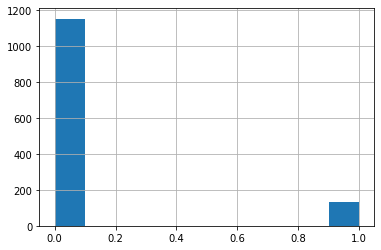

In [35]:
writings_per_user_df.label.hist()

In [36]:
train_df = writings_per_user_df[writings_per_user_df.index.isin(subjects_split['train'])][['text', 'label']]
test_df = writings_per_user_df[writings_per_user_df.index.isin(subjects_split['test'])][['text', 'label']]

In [37]:
# train_df = writings_df[writings_df.subject.isin(subjects_split['train'])][['text', 'label']]
# test_df = writings_df[writings_df.subject.isin(subjects_split['test'])][['text', 'label']]

In [38]:
len(train_df), len(test_df)

(472, 815)

In [39]:
train_df.groupby('label').count()

,text
label,
0,411
1,61


In [40]:
sorted([len(t) for t in test_df.text])

[340,
 373,
 423,
 441,
 658,
 710,
 719,
 756,
 777,
 778,
 885,
 1041,
 1075,
 1092,
 1135,
 1155,
 1238,
 1358,
 1391,
 1552,
 1623,
 1692,
 1730,
 1734,
 1776,
 1797,
 1845,
 1859,
 1899,
 1908,
 1931,
 1935,
 2041,
 2070,
 2134,
 2166,
 2191,
 2242,
 2308,
 2355,
 2423,
 2432,
 2434,
 2452,
 2483,
 2504,
 2544,
 2579,
 2584,
 2586,
 2610,
 2634,
 2639,
 2655,
 2662,
 2669,
 2671,
 2676,
 2692,
 2699,
 2707,
 2712,
 2713,
 2713,
 2715,
 2718,
 2721,
 2724,
 2728,
 2729,
 2732,
 2732,
 2737,
 2737,
 2737,
 2740,
 2744,
 2747,
 2749,
 2758,
 2758,
 2760,
 2761,
 2762,
 2764,
 2765,
 2765,
 2771,
 2771,
 2772,
 2773,
 2775,
 2777,
 2778,
 2779,
 2780,
 2784,
 2789,
 2791,
 2792,
 2794,
 2796,
 2797,
 2801,
 2801,
 2801,
 2802,
 2804,
 2804,
 2806,
 2806,
 2806,
 2812,
 2813,
 2813,
 2814,
 2814,
 2817,
 2820,
 2821,
 2821,
 2821,
 2821,
 2824,
 2828,
 2829,
 2830,
 2832,
 2833,
 2834,
 2835,
 2836,
 2836,
 2837,
 2840,
 2841,
 2842,
 2846,
 2846,
 2847,
 2850,
 2850,
 2851,
 2852,
 28

In [41]:
args = {
#    'model_type':  'roberta',
#    'model_name': 'roberta-base',
   'output_dir': 'outputs/',
   'cache_dir': 'cache/',
    'fp16': True,
   'fp16_opt_level': 'O1',
   'max_seq_length': 512, #seq_len, #256, #128,
    'sliding_window': False,
#     'stride': 1,
   'train_batch_size':4,
   'eval_batch_size':4,
   'gradient_accumulation_steps': 1,
   'num_train_epochs': 2,
#    'weight_decay': 0,
#    'weight_decay': 4e-5,
#    'learning_rate': 4e-5,
   'learning_rate': 4e-5,
   'adam_epsilon': 1e-8,
   'warmup_ratio': 0.06,
   'warmup_steps': 0,
   'max_grad_norm': 1.0,
    'logging_steps': 50,
   'evaluate_during_training': True,
   'save_steps': 2000,
   'eval_all_checkpoints': False,
    'evaluate_during_training': True,
    'evaluate_during_training_verbose': True,
    'evaluate_during_training_steps': 3,
   'use_tensorboard': True,
    'tensorboard_dir': 'tensorboard/roberta31',
    'overwrite_output_dir': True,
   'reprocess_input_data': False,
}

In [42]:
import torch
torch.backends.cuda.is_built()

True

In [43]:
# Create a TransformerModel
model = ClassificationModel('roberta', 'roberta-base', args=args, weight=[1, 6])
# model = ClassificationModel('albert', 'albert-base-v1', args=args, weight=[1, 12])
# model = ClassificationModel('bert', 'bert-base-uncased', args=args, weight=[1, 1])

In [44]:
from apex import amp

In [45]:
%%time

# Train the model
model.train_model(train_df=train_df, eval_df=test_df , acc=accuracy_score,
                                                          prec=precision_score,
                                                           f1=f1_score,
                                                         auc=roc_auc_score)#, auto_weights=True)



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:267: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.614638

/home/anasab/tf2conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.641670

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.570053

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.469419

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.311344

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.079857

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 2.827368Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.014709

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 3.255131Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 3.640997

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 3.337398Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.006085

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.008016

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.003291

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 2.701864

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 2.698069

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 1.470175

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.291477

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.128018

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.020131

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.005549

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.008868

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.043667

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.104736

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.194596

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.945680

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.716884

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.587215

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.845726

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.841649

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.468747

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.875199

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.335207

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 1.001423

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.321613

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 1.083483

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.164865

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.150222

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.013206

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 3.382429Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 3.427577

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 1.506361

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.038819

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.014564

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.012878


/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 2.011999

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.881616

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.773832

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anasab/tf2conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running loss: 0.094514

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.317054

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.274825

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.007655

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.005590

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.476521

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.003325

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.022691

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.002458

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.002194

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.005317

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.009480

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 1.329606

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.007793

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.001484

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 2.436206

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 1.042292

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.001425

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.066931

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 4.046536

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.025841

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.016586

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.011432

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 4.133573

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 2.571868

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.001987

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.007147

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.002488

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.003852

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.030310

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.042105

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.003706

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.003823

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.576352

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.004760

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.004786

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.004949


/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."



CPU times: user 14min 40s, sys: 1min 42s, total: 16min 22s
Wall time: 29min 26s


In [53]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df,
                                                           acc=accuracy_score,
                                                           prec=precision_score,
                                                            f1=f1_score, auc=roc_auc_score)

/home/anasab/tf2conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:690: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [54]:
result

{'mcc': 0.6745128849051766,
 'tp': 51,
 'tn': 721,
 'fp': 21,
 'fn': 22,
 'acc': 0.947239263803681,
 'prec': 0.7083333333333334,
 'f1': 0.703448275862069,
 'auc': 0.8351641250969243,
 'eval_loss': 0.4038912161349264}

In [48]:
def compute_metrics(result):
    accuracy = (result['tp'] + result['tn']) / (result['tp'] + result['tn'] + result['fp'] + result['fn'])    
    precision = result['tp'] / (result['tp'] + result['fp'])    
    recall = result['tp'] / (result['tp'] + result['fn'])    
    f1 = 2 * (precision * recall) / (precision + recall + 0.000001)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [49]:
compute_metrics(result)

{'accuracy': 0.947239263803681,
 'precision': 0.7083333333333334,
 'recall': 0.6986301369863014,
 'f1': 0.7034477758862056}

In [50]:
pd.Series([len(wrong_predictions[i].text_a.split()) for i in range(len(wrong_predictions))]).describe()

count     43.000000
mean     520.209302
std       56.868921
min      197.000000
25%      532.000000
50%      532.000000
75%      532.000000
max      532.000000
dtype: float64

In [51]:
pd.Series([len(t.text.split()) for t in writings_per_user_df.itertuples()]).describe()

count    1287.000000
mean      514.753691
std        70.998439
min        10.000000
25%       532.000000
50%       532.000000
75%       532.000000
max       532.000000
dtype: float64

In [52]:
print stop

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(stop)? (<ipython-input-52-74e119941311>, line 1)

# Recurrent NN

## Extract features and encode data

In [ ]:
hyperparams_features = {
    "max_features": 40000,
    # cut texts after this number of words
    # (among top max_features most common words)
    "maxlen": 500,
    "embedding_dim": 100,
    "user_level": True,
    "posts_per_user": 200,
    "batch_size": 32,
}


### Emotions

In [ ]:
def load_NRC(nrc_path):
    word_emotions = {}
    emotion_words = {}
    with open(nrc_path) as in_f:
        for line in in_f:
            line = line.strip()
            if not line:
                continue
            word, emotion, label = line.split()
            if word not in word_emotions:
                word_emotions[word] = set()
            if emotion not in emotion_words:
                emotion_words[emotion] = set()
            label = int(label)
            if label:
                word_emotions[word].add(emotion)
                emotion_words[emotion].add(word)
    return emotion_words

nrc_lexicon_path = root_dir + '/resources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_lexicon = load_NRC(nrc_lexicon_path)
emotions = list(nrc_lexicon.keys())


In [ ]:
def encode_emotions(tokens, emotion_lexicon, emotions, relative=True):
    text_len = len(tokens)
    encoded_emotions = [0 for e in emotions]
    for i, emotion in enumerate(emotions):
        try:
            emotion_words = [t for t in tokens if t in emotion_lexicon[emotion]]
            if relative:
                encoded_emotions[i] = len(emotion_words) / len(tokens)
            else:
                encoded_emotions[i] = len(emotion_words)
        except ValueError:
            print("Emotion not found.")
    return encoded_emotions

In [ ]:
from liwc_readDict import readDict

liwc = readDict(root_dir + '/resources/liwc.dic')

categories = set([c for (w,c) in liwc])
len(categories)

### Style features

#### Char n-grams

In [ ]:
def extract_ngrams(tokens):
    pass

#### Personal pronouns

In [ ]:
first_person_pronouns = {"i", "me", "my", "mine", "myself"}
def encode_pronouns(tokens, pronouns={"i", "me", "my", "mine", "myself"}, relative=True):
    if not tokens:
        return np.nan
    text_len = len(tokens)
    nr_pronouns = len([t for t in tokens if t in pronouns])
    if relative:
        return nr_pronouns/text_len
    else:
        return nr_pronouns

#### Stopwords

In [ ]:
stopword_list = stopwords.words("english")
def encode_stopwords(tokens, stopwords=stopword_list):
    encoded_stopwords = [0 for s in stopword_list]
    if not tokens:
        return encoded_stopwords
    for i, stopword in enumerate(stopwords):
        if stopword in tokens:
            encoded_stopwords[i] += 1
    return encoded_stopwords

### Topics

### Encode data

In [ ]:
from collections import Counter
def load_erisk_data(writings_df, voc_size, emotion_lexicon, seq_len, emotions =  
                    ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                     'negative', 'positive', 'sadness', 'surprise', 'trust'],
                    liwc_categories = categories,
                    pronouns = ["i", "me", "my", "mine", "myself"],
                    train_prop=0.7, valid_prop=0.3, test_slice=2,
                    nr_slices=5,
                    min_post_len=3, min_word_len=1, 
                    user_level=True, vocabulary=None,
                   logger=logger):
    logger.debug("Loading data...\n")
    if not vocabulary:
        vocabulary = {}
        word_freqs = Counter()
        for words in writings_df.tokenized_text:
            word_freqs.update(words)
        for words in writings_df.tokenized_title:
            word_freqs.update(words)
        i = 1
        for w, f in word_freqs.most_common(voc_size-2): # keeping voc_size-1 for unk
            if len(w) < min_word_len:
                continue
            vocabulary[w] = i
            i += 1
    tokens_data_train = []
    categ_data_train = []
    sparse_data_train = []
    tokens_data_valid = []
    categ_data_valid = []
    sparse_data_valid = []
    tokens_data_test = []
    categ_data_test = []
    sparse_data_test = []
    labels_train = []
    users_train = []
    labels_valid = []
    users_valid = []
    users_test = []
    labels_test = []
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    categories = [c for c in liwc_categories if c in writings_df.columns]
    logger.debug("%d training users, %d validation users, %d test users." % (
        len(training_subjects), 
          len(valid_subjects),
          len(test_subjects)))
    subjects_split = {'train': training_subjects, 
                      'valid': valid_subjects, 
                      'test': test_subjects}

    user_level_texts = {}
    for row in writings_df.sort_values(by='date').itertuples():
        words = []
        if row.tokenized_title:
            words.extend(row.tokenized_title)
        if row.tokenized_text:
            words.extend(row.tokenized_text)
        if not words or len(words)<min_post_len:
            print(row.subject)
            continue
        label = row.label
        liwc_categs = [getattr(row, categ) for categ in categories]
        if row.subject not in user_level_texts.keys():
            user_level_texts[row.subject] = {}
            user_level_texts[row.subject]['texts'] = [words]
            user_level_texts[row.subject]['label'] = label
            user_level_texts[row.subject]['liwc'] = [liwc_categs]
        else:
            user_level_texts[row.subject]['texts'].append(words)
            user_level_texts[row.subject]['liwc'].append(liwc_categs)
    return user_level_texts, subjects_split, vocabulary


In [ ]:
user_level_data, subjects_split, vocabulary = load_erisk_data(writings_df, 
                                                            seq_len=hyperparams_features['maxlen'],
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger
#                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
                                                                               )

### Data Generator

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, user_level_data, subjects_split, set_type='train',
                 batch_size=hyperparams_features['batch_size'], seq_len=hyperparams_features['maxlen'], 
                 voc_size=hyperparams_features['max_features'], emotion_lexicon=nrc_lexicon,
                 emotions=emotions, pronouns=["i", "me", "my", "mine", "myself"], 
                 max_posts_per_user=hyperparams_features['posts_per_user'],
                 shuffle=True):
        'Initialization'
        self.seq_len = seq_len
        self.subjects_split = subjects_split
        self.set = set_type
        self.emotion_lexicon = emotion_lexicon
        self.batch_size = batch_size
        self.data = user_level_data
        self.emotions = emotions
        self.pronouns = pronouns
        self.shuffle = shuffle
        self.voc_size = voc_size
        self.max_posts_per_user = max_posts_per_user
        self.on_epoch_end()

    def __encode_text(self, tokens):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [vocabulary.get(w, self.voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, self.emotion_lexicon, self.emotions)
        encoded_pronouns = encode_pronouns(tokens, self.pronouns)
        encoded_stopwords = encode_stopwords(tokens)
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.subjects_split[self.set]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        user_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find users
        users = [self.subjects_split[self.set][i] for i in user_indexes
                    if self.subjects_split[self.set][i] in self.data.keys()] # TODO: maybe needs a warning that user is missing

        post_indexes = {}
        # Sample post ids
        for subject in users:
            posts_len = len(self.data[subject]['texts'])
            posts_index_sample = sorted(np.random.choice(posts_len, 
                                                         min(self.max_posts_per_user, posts_len),
                                                         replace=False))
            post_indexes[subject] = posts_index_sample
        # Generate data
        X, y = self.__data_generation(users, post_indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.subjects_split[self.set]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, users, post_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        tokens_data = []
        categ_data = []
        sparse_data = []
        subjects = []
        labels = []
        for subject in users:
            texts = self.data[subject]['texts']
            label = self.data[subject]['label']
            
            # Sample
            texts = [texts[i] for i in post_indexes[subject]]
            liwc_selection = [self.data[subject]['liwc'][i] for i in post_indexes[subject]]
            all_words = [sum(texts, [])] # merge all texts in one list
            liwc_aggreg = [np.array(liwc_selection).mean(axis=0).tolist()]

            for i, words in enumerate(all_words):
                encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords = self.__encode_text(words)
                subject_id = int(subject.split('t')[1])
                tokens_data.append(encoded_tokens)
                categ_data.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
                sparse_data.append(encoded_stopwords)
                labels.append(label)
                subjects.append(subject_id)

        
        # using zeros for padding
        tokens_data_padded = sequence.pad_sequences(tokens_data, maxlen=self.seq_len)

        return ([np.array(tokens_data_padded), np.array(categ_data), np.array(sparse_data),
                np.array(subjects)],
                np.array(labels))


In [ ]:
class DataGeneratorHierarchical(Sequence):
    'Generates data for Keras'
    def __init__(self, user_level_data, subjects_split, set_type='train',
                 batch_size=hyperparams_features['batch_size'], seq_len=hyperparams_features['maxlen'], 
                 voc_size=hyperparams_features['max_features'], emotion_lexicon=nrc_lexicon,
                 emotions=emotions, pronouns=["i", "me", "my", "mine", "myself"], 
                 max_posts_per_user=hyperparams_features['posts_per_user'], stopwords=stopword_list,
                 liwc_categories=categories,
                 shuffle=True):
        'Initialization'
        self.seq_len = seq_len
        self.subjects_split = subjects_split
        self.set = set_type
        self.emotion_lexicon = emotion_lexicon
        self.batch_size = batch_size
        self.data = user_level_data
        self.emotions = emotions
        self.pronouns = pronouns
        self.shuffle = shuffle
        self.voc_size = voc_size
        self.max_posts_per_user = max_posts_per_user
        self.categ_dim = len(emotions) + 1 + len(liwc_categories)
        self.sparse_dim = len(stopwords)
        self.on_epoch_end()

    def __encode_text(self, tokens):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [vocabulary.get(w, self.voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, self.emotion_lexicon, self.emotions)
        encoded_pronouns = encode_pronouns(tokens, self.pronouns)
        encoded_stopwords = encode_stopwords(tokens)
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.subjects_split[self.set]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        user_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         if len(user_indexes)<self.batch_size:
#             return
        # Find users
        users = [self.subjects_split[self.set][i] for i in user_indexes
                    if self.subjects_split[self.set][i] in self.data.keys()] # TODO: maybe needs a warning that user is missing

        post_indexes = {}
        # Sample post ids
        for subject in users:
            posts_len = len(self.data[subject]['texts'])
            posts_index_sample = sorted(np.random.choice(posts_len, 
                                                         min(self.max_posts_per_user, posts_len),
                                                         replace=False))
            post_indexes[subject] = posts_index_sample
        # Generate data
        X, y = self.__data_generation(users, post_indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.subjects_split[self.set]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, users, post_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        user_tokens = []
        user_categ_data = []
        user_sparse_data = []
        
        labels = []
        for subject in users:
            tokens_data = []
            categ_data = []
            sparse_data = []
            
            texts = self.data[subject]['texts']
            label = self.data[subject]['label']
            
            # Sample
            texts = [texts[i] for i in post_indexes[subject]]
            if len(texts) < self.max_posts_per_user:
                # TODO: pad with zeros
                pass
                
            liwc_selection = [self.data[subject]['liwc'][i] for i in post_indexes[subject]]
            all_words = texts#= [sum(texts, [])] # merge all texts in one list
            liwc_aggreg = liwc_selection#[np.array(liwc_selection).mean(axis=0).tolist()]

            for i, words in enumerate(all_words):
                encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords = self.__encode_text(words)
                subject_id = int(subject.split('t')[1])
                tokens_data.append(encoded_tokens)
                # using zeros for padding
                categ_data.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
                sparse_data.append(encoded_stopwords)
            tokens_data_padded = np.array(sequence.pad_sequences(tokens_data, maxlen=self.seq_len))
            user_tokens.append(tokens_data_padded)

            user_categ_data.append(categ_data)
            user_sparse_data.append(sparse_data)

            labels.append(label)
        # TODO: check this is correct. for when there are fewer posts than minimum
        user_tokens = sequence.pad_sequences(user_tokens, value=np.zeros(self.seq_len))
        user_tokens = np.rollaxis(np.dstack(user_tokens), -1)
        
        user_categ_data = sequence.pad_sequences(user_categ_data, value=np.zeros(self.categ_dim))
        user_categ_data = np.rollaxis(np.dstack(user_categ_data), -1
                                     )
        user_sparse_data = sequence.pad_sequences(user_sparse_data, value=np.zeros(self.sparse_dim))
        user_sparse_data = np.rollaxis(np.dstack(user_sparse_data), -1)
        
        return ((user_tokens, user_categ_data, user_sparse_data),
                np.array(labels))


In [ ]:
logger.setLevel(logging.DEBUG)

# TODO: it is skipping the last batch
x_data = {'train': [], 'valid': [], 'test': []}
y_data = {'train': [], 'valid': [], 'test': []}
for set_type in ['train', 'valid', 'test']:
    total_positive = 0
    for x, y in DataGeneratorHierarchical(user_level_data, subjects_split, 
                                          set_type=set_type):
        total_positive += pd.Series(y).sum()
        x_data[set_type].append(x)
        y_data[set_type].append(y)
    logger.info("%d %s positive examples\n" % (total_positive, set_type))


In [ ]:
x[1].shape

In [ ]:
sum([len(subjects_split[s]) for s in ['train', 'valid', 'test']])

In [ ]:
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_data['train']),
#                                                  y_data['train'])
# class_weights

In [ ]:
def load_embeddings(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+2, embedding_dim)) - 0.5 # voc + unk + pad value(0)

    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
    f.close()

    print('Total %s word vectors.' % len(embedding_matrix))

 
    return embedding_matrix

pretrained_embeddings_path = root_dir + '/resources/glove.twitter.27B/glove.twitter.27B.%dd.txt' % hyperparams_features['embedding_dim']
embedding_matrix = load_embeddings(pretrained_embeddings_path, hyperparams_features['embedding_dim'], vocabulary)


## Define model

In [ ]:
hyperparams = {
    'lstm_units': 10,
    'lstm_units_user': 100,
    'dense_bow_units': 10,
    'dropout': 0.0,
    'l2_dense': 0.0000011,
    'l2_embeddings': 0.000001,
    'dense_sentence_units': 0,#50,
    'dense_user_units': 50,
    'optimizer': None,#'adam',
    'decay': 0.00001,
    'lr': 0.001,
    "trainable_embeddings": True,
    "reduce_lr_factor": 0.0002,
    "reduce_lr_patience": 50,
    "freeze_patience": 500,
    'threshold': 0.5,
    'ignore_layer': [],
    'norm_momentum': 0.1,

}
if not hyperparams['optimizer']:
    hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                   decay=hyperparams['decay'])

In [ ]:
class Metrics():
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def recall_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            possible_positives = K.sum(K.round(K.clip(y_labels, 0, 1)))
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

    def precision_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

    def f1_m(self, y_true, y_pred):
        precision = self.precision_m(y_true, y_pred)
        recall = self.recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

def binary_crossentropy_custom(y_true, y_pred):
    y_labels = y_true
    return K.binary_crossentropy(y_labels, 
                                 y_pred)

metrics_class = Metrics(threshold=hyperparams['threshold'])

In [ ]:
def build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[]):

    tokens_features = Input(shape=(hyperparams_features['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams_features['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)
#     if 'batchnorm' not in ignore_layer:
#         embedding_layer_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
#                                                      name='embeddings_layer_norm')(embedding_layer)
#     lstm_layers = Bidirectional(LSTM(hyperparams['lstm_units']))(embedding_layer)

    if tf.test.is_gpu_available():
        lstm_layers = CuDNNLSTM(hyperparams['lstm_units'], 
                                return_sequences='attention' not in ignore_layer, # only True if using attention
                      name='LSTM_layer')(embedding_layer)
    else:
        lstm_layers = LSTM(hyperparams['lstm_units'], 
                           return_sequences='attention' not in ignore_layer,
                      name='LSTM_layer')(embedding_layer)
    
    # Attention
    if 'attention' not in ignore_layer:
        attention = Dense(1, activation='tanh', name='attention')(lstm_layers)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        attention = RepeatVector(hyperparams['lstm_units'])(attention)
        attention = Permute([2, 1])(attention)

        sent_representation = Multiply()([lstm_layers, attention])
        sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)

        
    else:
        sent_representation = lstm_layers
        
    
    sent_representation = Dropout(hyperparams['dropout'], name='lstm_att_dropout')(sent_representation)
    if hyperparams['dense_sentence_units']:
        sent_representation = Dense(units=hyperparams['dense_sentence_units'],
                                   name='dense_sent_representation')(sent_representation)
    numerical_features = Input(shape=(len(emotions) + 1 + len(liwc_categories),), name='numeric_input') # emotions and pronouns
    dense_layer = Dense(units=1,
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                        name='numerical_dense_layer',
                       )(numerical_features)
    sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input') # stopwords

    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              )(sparse_features)
    
    if 'batchnorm' not in ignore_layer:
        numerical_features_norm = BatchNormalization(axis=-1, momentum=hyperparams['norm_momentum'],
                                                     name='numerical_features_norm')(numerical_features)
        sent_representation_norm = BatchNormalization(axis=-1, momentum=hyperparams['norm_momentum'],
                                                      name='sent_repr_norm')(sent_representation)
        dense_layer_sparse_norm = BatchNormalization(axis=-1, momentum=hyperparams['norm_momentum'],
                                                     name='sparse_features_norm')(dense_layer_sparse)
        
    subjects = Input(shape=(1,), name='subjects')
    

    all_layers = {
        'lstm_layers': sent_representation,
        'numerical_dense_layer': numerical_features,
        'sparse_feat_dense_layer': dense_layer_sparse
    }
    if 'batchnorm' not in ignore_layer:
        all_layers = {
            'lstm_layers': sent_representation_norm,
            'numerical_dense_layer': numerical_features_norm,
            'sparse_feat_dense_layer': dense_layer_sparse_norm
        }
    layers_to_merge = []
    for n, l in all_layers.items():
        if n in ignore_layer:
            continue
        layers_to_merge.append(l)
        
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
    output_layer = Dense(1, activation='sigmoid',
                         name='output_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']))(merged_layers)

    # Compile model
    model = Model(inputs=[tokens_features, numerical_features, sparse_features, subjects], 
                  outputs=output_layer)

    model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
    return model



In [ ]:
def build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[]):

    # Post/sentence representation - word sequence
    tokens_features = Input(shape=(hyperparams_features['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams_features['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)

    if tf.test.is_gpu_available():
        lstm_layers = CuDNNLSTM(hyperparams['lstm_units'], 
                                return_sequences='attention' not in ignore_layer, # only True if using attention
                      name='LSTM_layer')(embedding_layer)
    else:
        lstm_layers = LSTM(hyperparams['lstm_units'], 
                           return_sequences='attention' not in ignore_layer,
                      name='LSTM_layer')(embedding_layer)
    
    # Attention
    if 'attention' not in ignore_layer:
        attention = Dense(1, activation='tanh', name='attention')(lstm_layers)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        attention = RepeatVector(hyperparams['lstm_units'])(attention)
        attention = Permute([2, 1])(attention)

        sent_representation = Multiply()([lstm_layers, attention])
        sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)       
    else:
        sent_representation = lstm_layers
    
    if 'batchnorm' not in ignore_layer:
        sent_representation = BatchNormalization(axis=-1, momentum=hyperparams['norm_momentum'],
                                                          name='sent_repr_norm')(sent_representation)
    sent_representation = Dropout(hyperparams['dropout'], name='lstm_att_dropout')(sent_representation)
    

    # Hierarchy
    sentEncoder = Model(inputs=tokens_features, outputs=sent_representation)
    sentEncoder.summary()

    posts_history_input = Input(shape=(hyperparams_features['posts_per_user'], 
                                 hyperparams_features['maxlen']
                                      ), name='hierarchical_word_seq_input')

    user_encoder = TimeDistributed(sentEncoder, name='user_encoder')(posts_history_input)

    # Other features 
    numerical_features_history = Input(shape=(
            hyperparams_features['posts_per_user'],
            len(emotions) + 1 + len(liwc_categories)
        ), name='numeric_input_hist') # emotions and pronouns
    sparse_features_history = Input(shape=(
            hyperparams_features['posts_per_user'],
            len(stopwords_list)
        ), name='sparse_input_hist') # stopwords
    
    
    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              )
    dense_layer_sparse_user = TimeDistributed(dense_layer_sparse)(sparse_features_history)

    
    # Concatenate features
    if 'batchnorm' not in ignore_layer:
        numerical_features_history_norm = BatchNormalization(axis=-1, momentum=hyperparams['norm_momentum'],
                                                     name='numerical_features_norm')(numerical_features_history)
        dense_layer_sparse_user = BatchNormalization(axis=-1, momentum=hyperparams['norm_momentum'],
                                                     name='sparse_features_norm')(dense_layer_sparse_user)
    all_layers = {
        'lstm_layers': user_encoder,
        'numerical_dense_layer': numerical_features_history if 'batchnorm' in ignore_layer else numerical_features_history_norm,
        'sparse_feat_dense_layer': dense_layer_sparse_user
    }
    
    layers_to_merge = [l for n,l in all_layers.items() if n not in ignore_layer]
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
    
    if tf.test.is_gpu_available():
        lstm_user_layers = CuDNNLSTM(hyperparams['lstm_units_user'], 
                                return_sequences='attention_user' not in ignore_layer, # only True if using attention
                      name='LSTM_layer_user')(merged_layers)
    else:
        lstm_user_layers = LSTM(hyperparams['lstm_units_user'], 
                           return_sequences='attention_user' not in ignore_layer,
                      name='LSTM_layer_user')(merged_layers)
    
    # Attention
    if 'attention' not in ignore_layer:
        attention_user = Dense(1, activation='tanh', name='attention_user')(lstm_user_layers)
        attention_user = Flatten()(attention_user)
        attention_user = Activation('softmax')(attention_user)
        attention_user = RepeatVector(hyperparams['lstm_units_user'])(attention_user)
        attention_user = Permute([2, 1])(attention_user)

        user_representation = Multiply()([lstm_user_layers, attention_user])
        user_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units_user'],)
                                    )(user_representation)     
    else:
        user_representation = lstm_user_layers
    
    user_representation = Dropout(hyperparams['dropout'], name='lstm_att_dropout_user')(user_representation)
    
    
    if hyperparams['dense_user_units']:
        user_representation = Dense(units=hyperparams['dense_user_units'],
                                   name='dense_user_representation')(user_representation)
    
    # TODO: concatenate before hierarchy? (include all features in th hierarchy)
    
    output_layer = Dense(1, activation='sigmoid',
                         name='output_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']))(user_representation)

    # Compile model
    hierarchical_model = Model(inputs=[posts_history_input, numerical_features_history, sparse_features_history], 
                  outputs=output_layer)
    hierarchical_model.summary()
    
    hierarchical_model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
    return hierarchical_model



In [ ]:
model = build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
                    liwc_categories=[c for c in categories if c in writings_df.columns]
,
                   ignore_layer=hyperparams['ignore_layer'])


In [ ]:
plot_model(model, 'models/hierarchical_model.png')

In [ ]:
experiment = Experiment(api_key="eoBdVyznAhfg3bK9pZ58ZSXfv",
                        project_name="mental", workspace="ananana", disabled=True)

experiment.log_parameters(hyperparams_features)

experiment.log_parameter('emotion_lexicon', nrc_lexicon_path)
experiment.log_parameter('emotions', emotions)
experiment.log_parameter('embeddings_path', pretrained_embeddings_path)
if 'subset' in writings_df.columns:
    experiment.add_tag('anorexia')

experiment.log_parameters(hyperparams)

## Train

In [ ]:
class WeightsHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.log_weights(0)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.log_weights(epoch)
        
    def log_weights(self, step):
        for layer in model.layers:
            try:
                experiment.log_histogram_3d(layer.get_weights()[0], 
                                            name=layer.name, step=step)
            except Exception as e:
#                 logger.debug("Logging weights error: " + str(e) + "\n")
                # Layer probably does not exist
                pass


class FreezeLayer(callbacks.Callback):
    def __init__(self, logs={}, patience=5, layer={'user_encoder':'embeddings_layer'}, verbose=1, set_to=False):
        super(FreezeLayer, self).__init__()
        self.freeze_epoch = patience
        self.freeze_layer = layer
        self.verbose = verbose
        self.set_to = set_to

    def on_epoch_begin(self, epoch, logs={}):
        if type(self.freeze_layer)==dict:
            submodel = model.get_layer(list(self.freeze_layer.keys())[0])
        else:
            submodel = model
        logging.debug("Trainable embeddings", submodel.get_layer(self.freeze_layer).trainable)
        if epoch == self.freeze_epoch:
            try:
                layer = submodel.get_layer(self.freeze_layer)
                old_value = layer.trainable
                layer.trainable = self.set_to
                # TODO: does this reset the optimizer? should I also compile the top-level model?
                model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
                if self.verbose:
                    logging.debug("Setting %s layer from %s to trainable=%s...\n" % (layer.name, old_value,
                                                                   submodel.get_layer(self.freeze_layer).trainable))
            except Exception as e:
                # layer probably does not exist
                pass

In [ ]:
early_stopping_patience=50
def train_model(model, 
                data_generator_train, data_generator_valid,
                epochs, class_weight, start_epoch=0, workers=4,
                callback_list = [],
                model_path='/tmp/model',
               verbose=1):
    logging.info('Train...')
    experiment.log_parameter('class_weight', class_weight.values())
    experiment.log_parameter('callbacks', callbacks)

    history = model.fit_generator(data_generator_train,
                steps_per_epoch=100,
              epochs=epochs, initial_epoch=start_epoch, 
              class_weight=class_weight,
              validation_data=data_generator_valid,
                        verbose=verbose,
#               validation_split=0.3,
                       workers=workers,
            callbacks = [
                callbacks.ModelCheckpoint(filepath='%s_best' % model_path, verbose=1, 
                                          save_best_only=True),
                callbacks.EarlyStopping(patience=early_stopping_patience), *callback_list
            ])
    model.save(model_path)
    experiment.log_parameter('model_path', model_path)
    return model, history

In [ ]:
%%time

freeze_layer = FreezeLayer(patience=hyperparams['freeze_patience'], set_to=not hyperparams['trainable_embeddings'])
weights_history = WeightsHistory()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=hyperparams['reduce_lr_factor'],
                          patience=hyperparams['reduce_lr_patience'], min_lr=0.000001, verbose=1)
data_generator_train = DataGeneratorHierarchical(user_level_data, subjects_split, set_type='train',
                                                max_posts_per_user=hyperparams_features['posts_per_user'])
data_generator_valid = DataGeneratorHierarchical(user_level_data, subjects_split, set_type='valid',
                                                max_posts_per_user=hyperparams_features['posts_per_user'])
# Note: FreezeLayer callback doesn't work with hierarchical architecture
model, history = train_model(model, data_generator_train, data_generator_valid,
                       epochs=100,
                      class_weight={0:0.5, 1:5}, start_epoch=0,
                      callback_list = [],#[weights_history, reduce_lr],
                      model_path='models/ham_user_selfharm_seq1', workers=4)

In [ ]:
# TODO: properly extract the test data without sampling
model.evaluate(DataGenerator(user_level_data, subjects_split, set_type='test', max_posts_per_user=1000))

In [ ]:
dependencies = {
    'f1_m': metrics_class.f1_m,
    'precision_m': metrics_class.precision_m,
    'recall_m': metrics_class.recall_m,
    'binary_crossentropy_custom': binary_crossentropy_custom
}
model = load_model(model_path, custom_objects=dependencies)


In [ ]:
pd.Series([v for v in model.get_layer('attention').get_weights()[0].flatten()]).rolling(50).mean().plot()

In [ ]:
pd.Series([abs(v) for v in model.get_layer('output_layer').get_weights()[0].flatten()]).plot()

### Feature importance

In [ ]:
features = [
    (e, 'nrc') for e in emotions] + ['pers_pronouns'] + [
    (c, 'liwc') for c in list(categories) if c in writings_df.columns] + [
(st, 'stopword') for st in stopword_list]
weights = model.get_layer('output_layer').get_weights()[0].tolist()[-(len(features)):]

print(len(weights), len(features))
feature_importance = {}
for (i, f) in enumerate(features):
    feature_importance[f] = weights[i][0]

sorted(feature_importance.items(), key=lambda t: abs(t[1]), reverse=True)

## Evaluate per user

In [ ]:
def get_data_for_point(subject, voc, hyperparams_features=hyperparams_features, nrc_lexicon=nrc_lexicon,
                      emotions=emotions):
    eval_writings_df = writings_df[writings_df['subject']==subject]
    correct_label = eval_writings_df.label.values[0]
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(eval_writings_df,
                        seq_len=hyperparams_features['maxlen'],
                        voc_size=hyperparams_features['max_features'],
                        emotion_lexicon=nrc_lexicon,
                        emotions=emotions, user_level=False,
                        train_prop=0.0, vocabulary=voc)
    return x_test, y_test, correct_label

In [ ]:
def predict_per_user(writings_df, majority_prop=0.2, train_prop=0.7, majority_nr=0, validate=False, voc=None,
                    random=False, nr_slices=5, test_slice=2):
    all_predictions = []
    all_labels = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    thresh=0.5
    majority_proportion=majority_prop
    valid_prop = 0.3
    
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    
    if validate:
        subjects = valid_subjects
    else:
        subjects = test_subjects
    for subject in subjects:
        x_test_user, y_test_user, label = get_data_for_point(subject, voc=voc)
        outputs = model.predict(x_test_user)
        if random:
            sigma = np.std(outputs)
            mu = np.mean(outputs)
            print("generating random outputs with sigma", sigma, "and mu", mu)
            outputs = sigma*np.random.randn(len(outputs))+mu
        positive_pred = sum(outputs>=thresh)
        negative_pred = sum(outputs<thresh)
        majority_pred = 0
        if majority_proportion and positive_pred >= majority_proportion*negative_pred:
            majority_pred = 1
        if majority_nr and positive_pred>=majority_nr:
            majority_pred = 1
        if label == 1:
            if majority_pred == 1:
                tp+=1
            else:
                fn+=1
        else:
            if majority_pred == 0:
                tn+=1
            else:
                fp+=1
        print(negative_pred, positive_pred, majority_pred)
        all_predictions.append(majority_pred)
        all_labels.append(label)
    def prec_recall_f1(tp, fp, tn, fn):
        recall = tp/(tp+fn+0.0000001)
        precision = tp/(tp+fp+0.0000001)
        f1 = 2*precision*recall/(precision+recall+0.0000001)
        print("Recall", recall, "Precision", precision, "F1", f1)
    if majority_prop:
        print("Vote proportion", majority_prop)
    if majority_nr:
        print("Vote points", majority_nr)
    prec_recall_f1(tp, fp, tn, fn)

        

In [ ]:
predict_per_user(writings_df=writings_df, voc=voc, majority_prop=0.2)

## Cross-validation

In [ ]:
results_per_slice = {}

In [ ]:
nr_slices=5
logger.setLevel(logging.INFO)
for tslice in range(nr_slices): 
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(writings_df, 
                                                                seq_len=hyperparams_features['maxlen'],
                                                                voc_size=hyperparams_features['max_features'],
                                                               emotion_lexicon=nrc_lexicon,
                                                               emotions=emotions,
                                                               user_level=hyperparams_features['user_level'],
                                                                                    test_slice=tslice,
                                                                                    nr_slices=nr_slices,
    #                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
                                                                                   logger=logger)
    model, history = train_model(model, x_train, y_train, x_valid, y_valid,
           epochs=200, batch_size=hyperparams['batch_size'],
                      class_weight={0:0.5, 1:5}, start_epoch=0,
                      callback_list = [freeze_layer, weights_history, reduce_lr],
                      workers=2, verbose=0)
    results_per_slice[tslice] = model.evaluate(x_test, y_test)
    logger.info("Results for slice %d: %s\n" % (tslice, results_per_slice[tslice]))

In [ ]:
print("Average F1 score: ", np.array([results_per_slice[s][1] for s in results_per_slice.keys()]).mean(),
     "all F1 scores: ", {s: v[1] for (s,v) in results_per_slice.items()} )

## Extra analysis


In [ ]:
def merge_tokens(row):
    tokens = []
    if row.tokenized_text:
        tokens += row.tokenized_text
    if row.tokenized_title:
        tokens += row.tokenized_title
    return tokens
writings_df['all_tokens'] = writings_df.apply (lambda row: merge_tokens(row), axis=1)

In [ ]:
# TODO: include the title
def extract_emotions(tokens, emotion, relative=True):
    if not tokens:
        return None
    emotion_words = [t for t in tokens 
                     if t in nrc_lexicon[emotion]]
    if relative:
        return len(emotion_words) / len(tokens)
    else:
        return len(emotion_words)
    
    return encoded_emotions

from functools import partial
for emotion in emotions:
    writings_df[emotion] = writings_df['all_tokens'].apply(partial(extract_emotions, emotion=emotion, 
                                                                   relative=True))


In [ ]:
writings_df['pronouns'] = writings_df['all_tokens'].apply(partial(encode_pronouns, relative=True))

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].corr()

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].groupby('label').mean()

In [ ]:
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer

In [ ]:
sid = SentimentIntensityAnalyzer()


In [ ]:
sid.polarity_scores("We are here today happiness is all around")

In [ ]:
writings_df['neg_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['neg']
                                                 if type(t)==str else 0)

In [ ]:
writings_df

In [ ]:
writings_df['pos_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['pos']
                                                 if type(t)==str else 0)

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].groupby('label').mean()

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].corr('spearman')

### LIWC

In [ ]:
from liwc_readDict import readDict

liwc = readDict('/home/ana/resources/FakeOrFact/features/LIWC/LIWC/liwc.dic')

In [ ]:
categories = [c for (w,c) in liwc]
set(categories)

In [ ]:
liwc

In [ ]:
liwc_dict = {}
for (w, c) in liwc:
    if c not in liwc_dict:
        liwc_dict[c] = []
    liwc_dict[c].append(w)


In [ ]:
liwc_dict['pronoun']

In [ ]:
def encode_liwc_categories(tokens, category_words, relative=True):
    category_cnt = 0
    if not tokens:
        return None
    text_len = len(tokens)
    for t in tokens:
        for word in category_words:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
            or (t==word.split("'")[0]):
                category_cnt += 1
                break # one token cannot belong to more than one word in the category
    if relative:
        return category_cnt/text_len
    else:
        return category_cnt

In [ ]:
%%time
from functools import partial
# for categ in ['negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']:#liwc_dict.keys():
for categ in liwc_dict.keys():
    if categ in writings_df.columns:
        continue
    print("Encoding for category %s..." % categ)
    writings_df[categ] = writings_df['all_tokens'].apply(partial(encode_liwc_categories, 
                                                                   category_words=liwc_dict[categ], 
                                                                   relative=True))


In [ ]:
writings_df.groupby('subject').mean()[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].corr()

In [ ]:
writings_df[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].groupby('label').mean()

In [ ]:
writings_df.groupby('subject').mean()[['label'] + categories].corr()

## Hyperparameter tuning

In [ ]:
# Declare your hyperparameters search:
tune_epochs=150
config = {
      "algorithm": "random",
      "parameters": {
          "lstm_units": {"type": "integer", "min": 10, "max": 1000},
          "dense_bow_units": {"type": "integer", "min": 1, "max": 50},
          "lr": {"type": "float", "min": 0.00001, "max": 0.5, "scalingType": "loguniform"},
          "l2_dense": {"type": "float", "min": 0.0000001, "max": 0.05, "scalingType": "loguniform"},
          "l2_embeddings": {"type": "float", "min": 0.0000001, "max": 0.05, "scalingType": "loguniform"},
          "dropout": {"type": "float", "min": 0, "max": 0.7, "scalingType": "uniform"},
          "norm_momentum": {"type": "float", "min": 0.01, "max": 0.99, "scalingType": "uniform"},
          "optimizer": {"type": "categorical", "values": ["adam", "adagrad", ""]},
          "batch_size": {"type": "integer", "min": 10, "max": 512, "scalingType": "loguniform"},
          "positive_class_weight": {"type": "integer", "min": 1, "max": 25},
          "trainable_embeddings": {"type": "discrete", "values": [True, False]},
          "freeze_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "lr_reduce_factor": {"type": "float", "min": 0.0001, "max": 0.8},
          "lr_reduce_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "decay": {"type": "float", "min": 0.00000001, "max": 0.5, "scalingType": "loguniform"},
          "ignore_layers_values": {"type": "categorical", "values": ["attention", "batchnorm", ""]}
      },
      "spec": {
          "metric": "loss",
          "objective": "minimize",
      },
  }
optimizer = Optimizer(config, api_key="eoBdVyznAhfg3bK9pZ58ZSXfv")

for experiment in optimizer.get_experiments(project_name="mental"):
    experiment.add_tag("tune")
    
    # Test the model
    hyperparams_config = {
        param: experiment.get_parameter(param) for param in config['parameters'].keys()}
    if not hyperparams_config['optimizer']:
        hyperparams_config['optimizer'] = optimizers.Adam(lr=hyperparams_config['lr'], 
                                   decay=hyperparams_config['decay'])
    hyperparams_config["ignore_layers"] = []
    if hyperparams_config["ignore_layers_values"]:
        hyperparams_config["ignore_layers"] = [hyperparams_config["ignore_layers_values"]]
    model = build_model(hyperparams=hyperparams_config,
                        hyperparams_features=hyperparams_features, 
                        embedding_matrix=embedding_matrix, emotions=emotions,
                       stopwords_list=stopword_list, liwc_categories=categories)
    freeze_layer = FreezeLayer(patience=experiment.get_parameter('freeze_patience'),
                              set_to=not experiment.get_parameter('trainable_embeddings'))
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=experiment.get_parameter('lr_reduce_factor'),
                                            patience=experiment.get_parameter('lr_reduce_patience'), 
                                            min_lr=0.000001, verbose=1)
    model, history = train_model(model, 
            x_train, y_train, x_test, y_test,
            epochs=tune_epochs, batch_size=experiment.get_parameter('batch_size'),
                      class_weight={0:1, 1:experiment.get_parameter('positive_class_weight')}, 
                          workers=2,
                          callback_list = [freeze_layer, reduce_lr],
                      model_path='models/experiment')
    loss = history.history['loss'][-1]
    
    # Report the loss, if not auto-logged:
    experiment.log_metric("loss", loss)